In [1]:
import os
import tempfile
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
# import scrublet as scr
import scvi
import torch
import time

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [8]:
!mkdir ../ref_models/06_scArches
!mkdir ../results/06_scArches

mkdir: cannot create directory ‘../ref_models/06_scArches’: File exists
mkdir: cannot create directory ‘../results/06_scArches’: File exists


## PBMC task

In [9]:
scvi_ref_path = "../ref_models/06_scArches/PBMC_ref.scvi"

### Model building

In [10]:
adata_ref = sc.read_h5ad("../data/DISCO_hPBMC.train.counts.h5ad")
adata_ref.layers["counts"] = adata_ref.X.tocsr()
sc.pp.highly_variable_genes(
    adata_ref,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="project_id",
    subset=True
)

In [11]:
time0 = time.time()
scvi.model.SCVI.setup_anndata(adata_ref, layer="counts", batch_key="project_id")
vae = scvi.model.SCVI(adata_ref, use_layer_norm="both", use_batch_norm="none", encode_covariates=True, n_layers=2, dropout_rate=0.2)
vae.train()
adata_ref.obsm["X_scVI"] = vae.get_latent_representation()
time1 = time.time()
runtime1 = time1 - time0
runtime1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53/53: 100%|█| 53/53 [06:10<00:00,  6.99s/it, v_num=1, train_loss_step=461, train

`Trainer.fit` stopped: `max_epochs=53` reached.


Epoch 53/53: 100%|█| 53/53 [06:10<00:00,  7.00s/it, v_num=1, train_loss_step=461, train


373.5318183898926

In [23]:
## saving reference
vae.save(scvi_ref_path, overwrite=True)
adata_ref.write_h5ad("../ref_models/06_scArches/PBMC_ref.scvi.h5ad")

### Reference mapping

In [17]:
adata_query = sc.read_h5ad("../data/DISCO_hPBMC.test.counts.h5ad")
adata_query.layers["counts"] = adata_query.X.tocsr()

In [19]:
time0 = time.time()
scvi.model.SCVI.prepare_query_anndata(adata_query, scvi_ref_path)
scvi_query = scvi.model.SCVI.load_query_data(adata_query, scvi_ref_path)
scvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})
time1 = time.time()
runtime2 = time1 - time0
runtime2

INFO     File ../ref_models/06_scArches/PBMC_ref.scvi/model.pt already downloaded                                  
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../ref_models/06_scArches/PBMC_ref.scvi/model.pt already downloaded                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|█| 200/200 [02:36<00:00,  1.24it/s, v_num=1, train_loss_step=541, t

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [02:36<00:00,  1.28it/s, v_num=1, train_loss_step=541, t


156.81270098686218

In [24]:
adata_query.obsm["X_scVI"] = scvi_query.get_latent_representation()
adata = anndata.concat([adata_query, adata_ref])
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


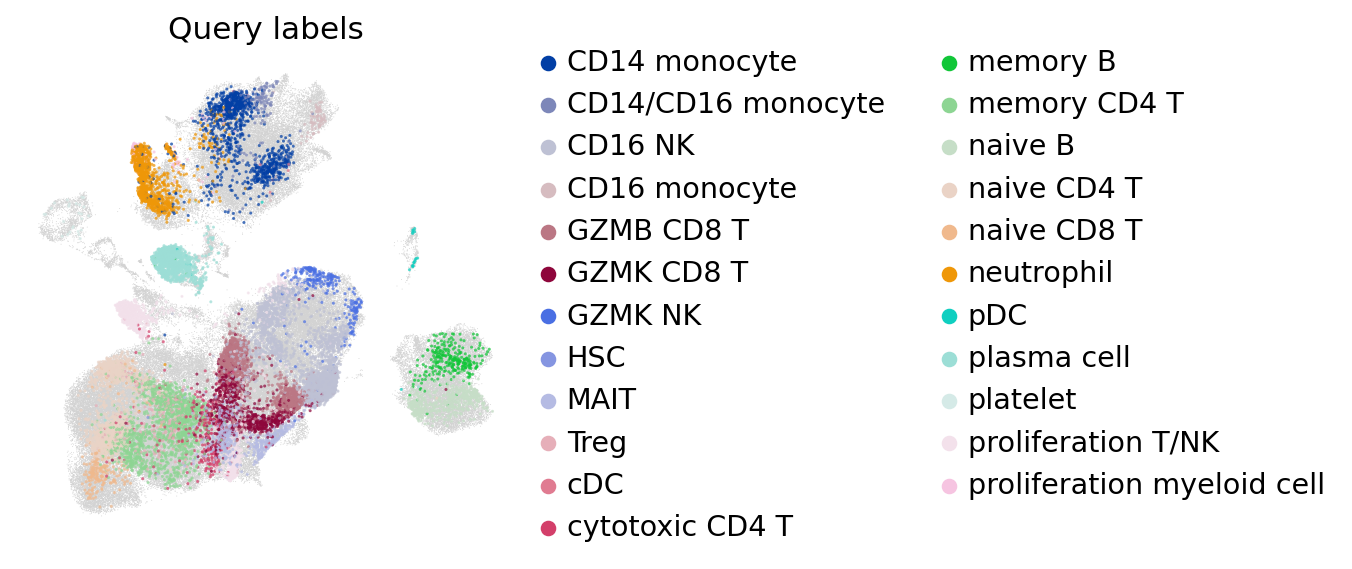

In [25]:
ax = sc.pl.umap(
    adata,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata[: adata_query.n_obs],
    color=["cell_subtype"],
    frameon=False,
    title="Query labels",
    ax=ax,
    alpha=0.7,
)

### Saving results

In [52]:
umap_emb = pd.DataFrame(adata.obsm["X_umap"])
umap_emb.index = adata.obs.index
umap_emb.columns = ["Dim_1", "Dim_2"]

cellmeta = pd.DataFrame(adata.obs["cell_subtype"])

In [53]:
ref_emb = umap_emb.loc[adata_ref.obs.index]
query_emb = umap_emb.loc[adata_query.obs.index]

ref_cellmeta = cellmeta.loc[adata_ref.obs.index]
query_cellmeta = cellmeta.loc[adata_query.obs.index]
ref_cellmeta["group"] = "reference"
query_cellmeta["group"] = "query"
ref_cellmeta.columns = ["label", "group"]
query_cellmeta.columns = ["label", "group"]

In [64]:
ref_emb.to_csv("../results/06_scArches/PBMC_ref_embeddings.csv")
ref_cellmeta.to_csv("../results/06_scArches/PBMC_ref_cellmeta.csv")
query_emb.to_csv("../results/06_scArches/PBMC_query_embeddings.csv")
query_cellmeta.to_csv("../results/06_scArches/PBMC_query_cellmeta.csv")
# run time
runtime = {"model.building": [runtime1], "reference.mapping": [runtime2]}
runtime = pd.DataFrame(runtime)
runtime.to_csv("../results/06_scArches/PBMC_runtime.csv")

## MFI task

In [2]:
scvi_ref_path = "../ref_models/06_scArches/MFI_ref.scvi"

### Model building

In [20]:
adata_ref = sc.read_h5ad("../data/Vento2018.MFI.train.counts.h5ad")
adata_ref.layers["counts"] = adata_ref.X.tocsr()

In [21]:
# set span=0.5 to avoid this issue:
# https://github.com/scverse/scanpy/issues/2669
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="orig.ident",
    subset=True, 
    span=0.5
)

In [22]:
time0 = time.time()
scvi.model.SCVI.setup_anndata(adata_ref, layer="counts", batch_key="orig.ident")
vae = scvi.model.SCVI(adata_ref, use_layer_norm="both", use_batch_norm="none", encode_covariates=True, n_layers=2, dropout_rate=0.2)
vae.train()
adata_ref.obsm["X_scVI"] = vae.get_latent_representation()
time1 = time.time()
runtime1 = time1 - time0
runtime1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 135/135: 100%|██████████████| 135/135 [05:13<00:00,  2.31s/it, v_num=1, train_loss_step=935, train_loss_epoch=907]

`Trainer.fit` stopped: `max_epochs=135` reached.


Epoch 135/135: 100%|██████████████| 135/135 [05:13<00:00,  2.33s/it, v_num=1, train_loss_step=935, train_loss_epoch=907]


316.7725553512573

In [23]:
scvi_ref_path

'../ref_models/06_scArches/MFI_ref.scvi'

In [24]:
## saving reference
vae.save(scvi_ref_path, overwrite=True)
adata_ref.write_h5ad("../ref_models/06_scArches/MFI_ref.scvi.h5ad")

### Reference mapping

In [25]:
adata_query = sc.read_h5ad("../data/Vento2018.MFI.test.counts.h5ad")
adata_query.layers["counts"] = adata_query.X.tocsr()

In [26]:
time0 = time.time()
scvi.model.SCVI.prepare_query_anndata(adata_query, scvi_ref_path)
scvi_query = scvi.model.SCVI.load_query_data(adata_query, scvi_ref_path)
scvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})
time1 = time.time()
runtime2 = time1 - time0
runtime2

INFO     File ../ref_models/06_scArches/MFI_ref.scvi/model.pt already downloaded                                   
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../ref_models/06_scArches/MFI_ref.scvi/model.pt already downloaded                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████████| 200/200 [01:49<00:00,  1.83it/s, v_num=1, train_loss_step=805, train_loss_epoch=795]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████████| 200/200 [01:49<00:00,  1.82it/s, v_num=1, train_loss_step=805, train_loss_epoch=795]


110.17187404632568

In [27]:
adata_query.obsm["X_scVI"] = scvi_query.get_latent_representation()
adata = anndata.concat([adata_query, adata_ref])
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


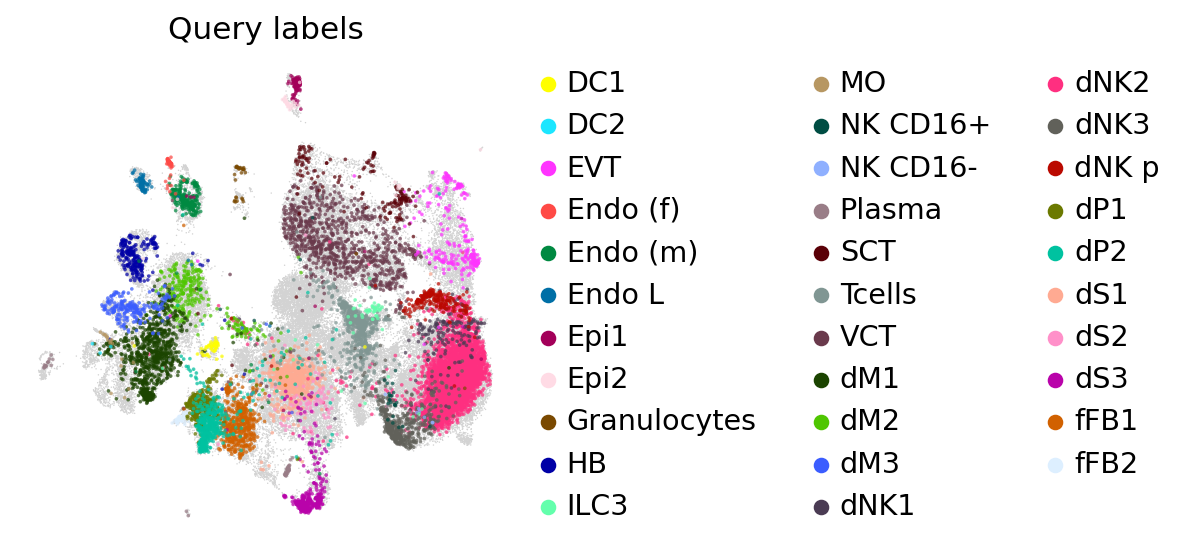

In [28]:
ax = sc.pl.umap(
    adata,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata[: adata_query.n_obs],
    color=["annotation"],
    frameon=False,
    title="Query labels",
    ax=ax,
    alpha=0.7,
)

### Saving results

In [29]:
umap_emb = pd.DataFrame(adata.obsm["X_umap"])
umap_emb.index = adata.obs.index
umap_emb.columns = ["Dim_1", "Dim_2"]

cellmeta = pd.DataFrame(adata.obs["annotation"])

In [30]:
ref_emb = umap_emb.loc[adata_ref.obs.index]
query_emb = umap_emb.loc[adata_query.obs.index]

ref_cellmeta = cellmeta.loc[adata_ref.obs.index]
query_cellmeta = cellmeta.loc[adata_query.obs.index]
ref_cellmeta["group"] = "reference"
query_cellmeta["group"] = "query"
ref_cellmeta.columns = ["label", "group"]
query_cellmeta.columns = ["label", "group"]

In [32]:
task_id = "MFI"
ref_emb.to_csv(f"../results/06_scArches/{task_id}_ref_embeddings.csv")
ref_cellmeta.to_csv(f"../results/06_scArches/{task_id}_ref_cellmeta.csv")
query_emb.to_csv(f"../results/06_scArches/{task_id}_query_embeddings.csv")
query_cellmeta.to_csv(f"../results/06_scArches/{task_id}_query_cellmeta.csv")
# run time
runtime = {"model.building": [runtime1], "reference.mapping": [runtime2]}
runtime = pd.DataFrame(runtime)
runtime.to_csv(f"../results/06_scArches/{task_id}_runtime.csv")

## mTCA task

In [33]:
scvi_ref_path = "../ref_models/06_scArches/mTCA_ref.scvi"

### Model building

In [34]:
adata_ref = sc.read_h5ad("../data/mTCA.train.counts.h5ad")
adata_ref.layers["counts"] = adata_ref.X.tocsr()

In [35]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="GSE_ID",
    subset=True
)

In [36]:
time0 = time.time()
scvi.model.SCVI.setup_anndata(adata_ref, layer="counts", batch_key="GSM_ID")
vae = scvi.model.SCVI(adata_ref, use_layer_norm="both", use_batch_norm="none", encode_covariates=True, n_layers=2, dropout_rate=0.2)
vae.train()
adata_ref.obsm["X_scVI"] = vae.get_latent_representation()
time1 = time.time()
runtime1 = time1 - time0
runtime1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 46/46: 100%|██████████████████| 46/46 [05:27<00:00,  7.36s/it, v_num=1, train_loss_step=809, train_loss_epoch=739]

`Trainer.fit` stopped: `max_epochs=46` reached.


Epoch 46/46: 100%|██████████████████| 46/46 [05:27<00:00,  7.11s/it, v_num=1, train_loss_step=809, train_loss_epoch=739]


329.1879780292511

In [37]:
scvi_ref_path

'../ref_models/06_scArches/mTCA_ref.scvi'

In [38]:
## saving reference
vae.save(scvi_ref_path, overwrite=True)
adata_ref.write_h5ad("../ref_models/06_scArches/MFI_ref.scvi.h5ad")

### Reference mapping

In [39]:
adata_query = sc.read_h5ad("../data/mTCA.test.counts.h5ad")
adata_query.layers["counts"] = adata_query.X.tocsr()

In [40]:
time0 = time.time()
scvi.model.SCVI.prepare_query_anndata(adata_query, scvi_ref_path)
scvi_query = scvi.model.SCVI.load_query_data(adata_query, scvi_ref_path)
scvi_query.train(max_epochs=200, early_stopping=True, plan_kwargs={"weight_decay": 0.0})
time1 = time.time()
runtime2 = time1 - time0
runtime2

INFO     File ../ref_models/06_scArches/mTCA_ref.scvi/model.pt already downloaded                                  
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../ref_models/06_scArches/mTCA_ref.scvi/model.pt already downloaded                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████████| 200/200 [02:15<00:00,  1.51it/s, v_num=1, train_loss_step=636, train_loss_epoch=725]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████████| 200/200 [02:15<00:00,  1.48it/s, v_num=1, train_loss_step=636, train_loss_epoch=725]


135.78544425964355

In [41]:
adata_query.obsm["X_scVI"] = scvi_query.get_latent_representation()
adata = anndata.concat([adata_query, adata_ref])
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jarning/miniconda3/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


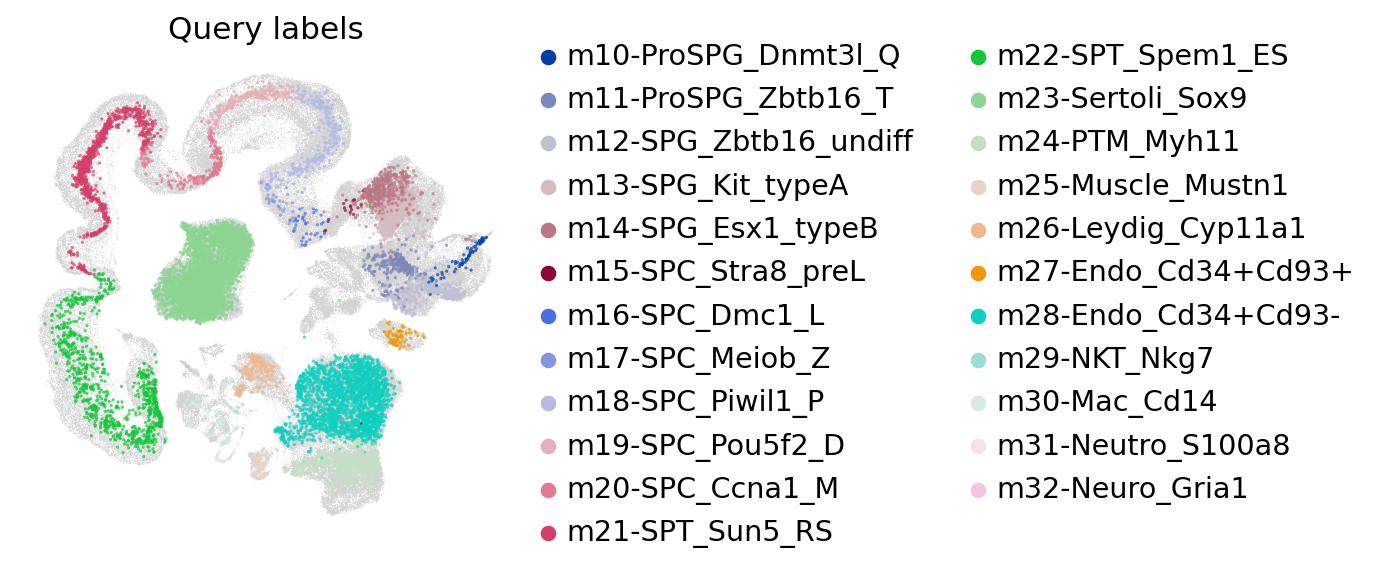

In [43]:
ax = sc.pl.umap(
    adata,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata[: adata_query.n_obs],
    color=["Cell_type_symbol"],
    frameon=False,
    title="Query labels",
    ax=ax,
    alpha=0.7,
)

### Saving results

In [44]:
umap_emb = pd.DataFrame(adata.obsm["X_umap"])
umap_emb.index = adata.obs.index
umap_emb.columns = ["Dim_1", "Dim_2"]

cellmeta = pd.DataFrame(adata.obs["Cell_type_symbol"])

In [45]:
ref_emb = umap_emb.loc[adata_ref.obs.index]
query_emb = umap_emb.loc[adata_query.obs.index]

ref_cellmeta = cellmeta.loc[adata_ref.obs.index]
query_cellmeta = cellmeta.loc[adata_query.obs.index]
ref_cellmeta["group"] = "reference"
query_cellmeta["group"] = "query"
ref_cellmeta.columns = ["label", "group"]
query_cellmeta.columns = ["label", "group"]

In [46]:
task_id = "mTCA"
ref_emb.to_csv(f"../results/06_scArches/{task_id}_ref_embeddings.csv")
ref_cellmeta.to_csv(f"../results/06_scArches/{task_id}_ref_cellmeta.csv")
query_emb.to_csv(f"../results/06_scArches/{task_id}_query_embeddings.csv")
query_cellmeta.to_csv(f"../results/06_scArches/{task_id}_query_cellmeta.csv")
# run time
runtime = {"model.building": [runtime1], "reference.mapping": [runtime2]}
runtime = pd.DataFrame(runtime)
runtime.to_csv(f"../results/06_scArches/{task_id}_runtime.csv")